Engy-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **18Oct21**

# Homework 04 (19Oct21)

$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

### Name: `Shubhojit Banerjee`

### Rubric for each assignment: 

|       Context               |  Points |
| -----------------------     | ------- |
| Precision of the answer     |   80%   |
| Answer Markdown readability |   10%   |
| Code readability            |   10%   |

### <span style="color:red">Guidance:</span>

+  <span style="color:red"> 
    Save your work frequently to a file locally to your computer.
   </span>
+  <span style="color:red">
    During your work and before submitting the final version do:</span> Kernel -> Restart & Run All<span style="color:red">, to verify your notebook runs correctly.
   </span>
+  <span style="color:red">
    Save your file again.
   </span>
+  <span style="color:red">
    Upload the notebook file in the Blackboard submission portal as: 
   </span> 
   
   **lastname-firstname-labwork-xx.ipynb**

---
## Table of Assignments<a id="toa"></a>
* [Assignment 1 (30 pts)](#a1) Function approximation with Lagrange finite element basis functions.
 - [1.1)](#a11)(5 pts) Generate the target function.
 - [1.2)](#a12)(10 pts) Compute parameters for a given error level.
 - [1.3)](#a13)(15 pts) Using the same basis functions, approximate the target function continuously ($m\rightarrow\infty$) and constrain the end points.
* [Assignment 2 (65 pts)](#a2) Nuclear heat conduction model problem.
- [2.1)](#a21)(30 pts) Fully functional fuel pin.
- [2.2)](#a22)(35 pts) Fuel pin with heat generation defect.
* [Assignment 3 (5 pts)](#a3) .
---

## <span style="color:blue">[Assignment 1 (45 pts)](#toa)</span><a id="a1"></a>

### <span style="color:blue">[1.1)](#toa)(5 pts) Generate the following piecewise linear function on these shape points:</span>
<br>
<span style="color:blue">
  $\{(-8,1),(-6,10),(-5,-7),(0,-5),(1,9),(2,-8),(3,28),(5,-23),(7,12),(9,1),(10,10),(12,15),(14,18),(15,10)\}$.
</span><a id="a11"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.linalg import solve,norm
import math
from scipy.integrate import quad
from numpy.linalg import matrix_rank
from scipy.interpolate import UnivariateSpline
from colorama import Fore
color=Fore.BLUE
plt.style.use('dark_background')

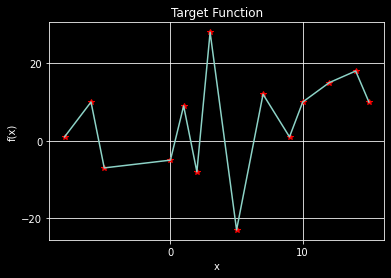

In [2]:
'''Generate the target function f'''
'''Generate the target function f'''
Shap_point=[(-8,1),(-6,10),(-5,-7),(0,-5),(1,9),(2,-8),(3,28),(5,-23),(7,12),(9,1),(10,10),(12,15),(14,18),(15,10)]
Shape= np.array(Shap_point)
#print(Shape[:,0])
x_min=Shape[:,0][0]
x_max=Shape[:,0][-1]
m=100
new_x = np.linspace(x_min,x_max,m)
f= interp1d(Shape[:,0], Shape[:,1])
new_f= f(Shape[:,0])
plt.plot(Shape[:,0], Shape[:,1], '*', color='red')
plt.grid(True)
plt.plot(Shape[:,0],new_f)
plt.title('Target Function')
plt.xlabel('x');plt.ylabel('f(x)')
plt.rcParams.update({'font.size': 22})
plt.show()
#print(i_p(x_min))



### <span style="color:blue">[1.2)](#toa)(20 pts) Compute "the best" approximant function $g$ using Lagrange finite element basis functions with **reduced values of parameters** (as reduced as you can find) to approximate $f$ with a relative $L^2$ norm below 30% error; use a continuous approximation equivalent to an infinite number of collocation points ($m\rightarrow\infty$). Report the number of elements and degree of polynomial used, show a comparison plot, compute the $L^2$ norm relative error. Explain why the end points of the approximation do not match the given data.
</span><a id="a12"></a>

In [3]:
degree=2
n_elem=7

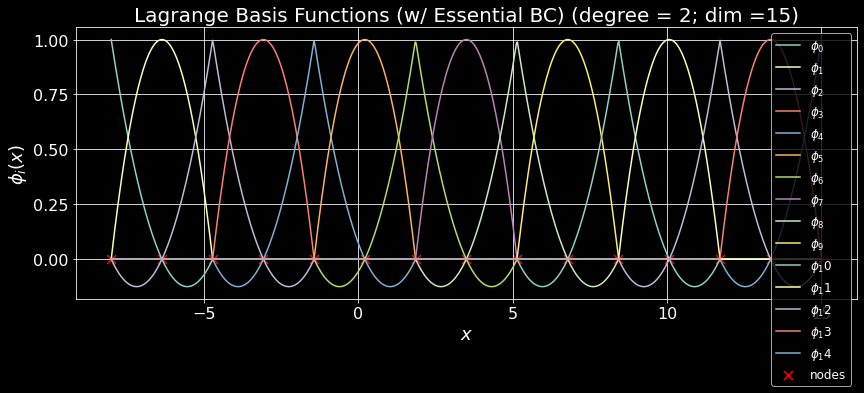

In [4]:
'''Domain partition'''
def get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='flux', bc_x_max='flux'):
    #assert degree == 1
    # Local node numbering on parent domain
    # --0--------------1---->
    #  -1      0      +1    zetta
    gnodes_x = np.linspace(x_min, x_max, n_elem*degree+1, dtype=np.float64)
    patches = list()
    local_to_global_node_id_map = list()
    for e in range(n_elem):
        gnode_id_1 = degree*e   #left
        gnode_id_2 = degree*e+1 #center
        gnode_id_3 = degree*e+2 #right
        x1 = gnodes_x[gnode_id_1]
        x2 = gnodes_x[gnode_id_2]
        x3 = gnodes_x[gnode_id_3]
        # Local node id:  0   1
        patches.append((x1, x2, x3))
        # Local node id:                        0           2             1
        local_to_global_node_id_map.append([gnode_id_1, gnode_id_2,  gnode_id_3])
    if bc_x_min == 'essential':
        local_to_global_node_id_map[0][0] = -1
    if bc_x_max == 'essential':
        local_to_global_node_id_map[-1][-1] = -1
    return (patches, gnodes_x, local_to_global_node_id_map)

def get_parent_mapping():
    # zeta in [-1,1]
    parent_mapping = lambda zeta, x_e_bar, h_e: x_e_bar + h_e/2*zeta # compute x
    parent_mapping_prime = lambda h_e: h_e/2                           # compute mapping derivative wrt zeta
    # x in Omega_e
    inverse_parent_mapping = lambda x, x_e_bar, h_e: (x - x_e_bar)*2/h_e # compute zeta
    inverse_parent_mapping_prime = lambda h_e: 2/h_e # compute zeta
    return (parent_mapping, parent_mapping_prime, inverse_parent_mapping, inverse_parent_mapping_prime)

def get_parent_basis_functions():
    parent_basis_func_list = list()
    parent_basis_func_prime_list = list()
    parent_basis_func_list.append(lambda zetta: (zetta**2-zetta)/2)  # left
    parent_basis_func_list.append(lambda zetta: -(zetta**2-1))  # middle
    parent_basis_func_list.append(lambda zetta:  (zetta**2+zetta)/2)  # right
    parent_basis_func_prime_list.append(lambda zetta: (2*zetta-1)/2) # left
    parent_basis_func_prime_list.append(lambda zetta: -2*zetta) # middle
    parent_basis_func_prime_list.append(lambda zetta:  (2*zetta+1)/2) # right
    return (parent_basis_func_list, parent_basis_func_prime_list)

def global_basis_function(i, x, domain_partition, parent_mapping, parent_basis_functions):
  
    try:
        len(x)
    except TypeError:
        x = np.array([x])
  
    if not isinstance(x, np.ndarray):
       assert isinstance(x, list) or isinstance(x, tuple)
       x = np.array(x)
  
    phi_i_x = np.copy(x) * 0.0 # initialization
    phi_prime_i_x = np.copy(x) * 0.0 # initialization
        
    patches = domain_partition[0]
    local_to_global_node_id_map = domain_partition[2]
    inverse_parent_mapping = parent_mapping[2]
    
    parent_basis_func_list = parent_basis_functions[0]
    parent_basis_func_prime_list = parent_basis_functions[1]
  
    # expensive reverse lookup
    for j, x_j in enumerate(x):
        for e, nodes_x in enumerate(patches):
            if nodes_x[0] <= x_j <= nodes_x[-1]:
                n_lnodes = len(nodes_x)
                for I in range(n_lnodes):
                    if local_to_global_node_id_map[e][I] == i:
                        x_e_bar = (nodes_x[0] + nodes_x[-1])/2
                        h_e = nodes_x[-1] - nodes_x[0]
                        zetta = inverse_parent_mapping(x_j, x_e_bar, h_e)
                        phi_i_x[j] = parent_basis_func_list[I](zetta)
                        phi_prime_i_x[j] = parent_basis_func_prime_list[I](zetta)
                break
    return [phi_i_x, phi_prime_i_x]

def get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function):
    
    basis_func_list = list()
    basis_func_prime_list = list()
    n_gnodes = domain_partition[1].size
    local_to_global_node_id_map = domain_partition[2]
    phi_i = lambda i, x: global_basis_function(i,x, domain_partition,parent_mapping,parent_basis_functions)[0]
    phi_prime_i = lambda i, x: global_basis_function(i,x, domain_partition,parent_mapping,parent_basis_functions)[1]


    visited = [False]*n_gnodes
    for e in range(n_elem):
        for I in range(len(local_to_global_node_id_map[e])):
            gnode_id = local_to_global_node_id_map[e][I]
            if gnode_id >= 0 and not visited[gnode_id]:
                      basis_func_list.append(lambda x, i=gnode_id: phi_i(i,x))
                      basis_func_prime_list.append(lambda x, i=gnode_id: phi_prime_i(i,x))
                        
                      visited[gnode_id] = True
  
    assert len(basis_func_list) >= 1, 'There are no basis functions to build.'
    return [basis_func_list, basis_func_prime_list]








# It is implied here the boundary conditions are of type: flux
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()


phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

#print(phi_list)

def plot(npts=200, title='Lagrange Basis Functions'):
    
    
    #%matplotlib inline
    #plt.style.use('classic')
    plt.figure(1, figsize=(14, 5))

    x_pts = np.linspace(x_min, x_max, npts)
    for (i,phi_i) in enumerate(phi_list):
        plt.plot(x_pts, phi_i(x_pts),'-',label=r'$\phi_%i$'%i)

    gnodes_x = domain_partition[1]
    plt.scatter(gnodes_x, np.zeros(gnodes_x.size), color='red', marker='x', s=80, label='nodes')

    plt.title(title, fontsize=20)
    plt.ylabel(r'$\phi_i(x)$', fontsize=18)
    plt.xlabel(r'$x$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()



plot(npts=800, title=r'Lagrange Basis Functions (w/ Essential BC) (degree = %i; dim =%i'%(degree, len(phi_list))+')')


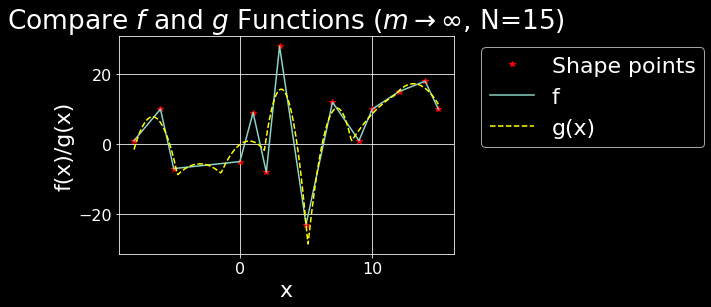

In [5]:
'''Plot comparison of f and g_best_vec'''
def inner_product(u, v, patches):
    integrand = lambda x: u(x) * v(x)          
    inner_product = 0.0
    for nodes_x in patches:
        (inner_product_e, _) = quad(integrand, nodes_x[0], nodes_x[-1])
        inner_product += inner_product_e           
    return inner_product


'''Pedagogical Gram matrix'''
def get_gram_matrix(basis_func_list, domain_partition, inner_product):
    N = len(basis_func_list)
    patches = domain_partition[0]
    a_mtrx = np.zeros((N, N), dtype=np.float64)
    for i,phi_i in enumerate(basis_func_list):
        for j,phi_j in enumerate(basis_func_list):
            a_mtrx[i,j] = inner_product(phi_i, phi_j, patches)    
    return a_mtrx


b_vec = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]
for i, phi_i in enumerate(phi_list):
    b_vec[i] = inner_product(f, phi_i, patches) 
    
gram_mtrx = get_gram_matrix(phi_list, domain_partition, inner_product)
#np.set_printoptions(precision=2, edgeitems=6, threshold=200, linewidth=150)
gram_mtrx = get_gram_matrix(phi_list, domain_partition, inner_product)


c_star_vec = np.linalg.solve(gram_mtrx, b_vec)

n_pts = 300
x_pts = np.linspace(x_min, x_max, n_pts)


    
def g(x,c_star_vec):
    g_x=0
    
    for (j,phi_j) in enumerate(phi_list):
        g_x=g_x+(c_star_vec[int(j)])*phi_j(x)
    
    return g_x

    
    
g_best=g(x_pts,c_star_vec)
#print(g_best)
plt.plot(Shape[:,0], Shape[:,1], '*', color='red',label='Shape points')
plt.plot(Shape[:,0], new_f,label='f')
plt.grid()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(x_pts,g_best,'--',label='g(x)', color='yellow')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('x');plt.ylabel("f(x)/g(x)")
plt.title(r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, N='+str(len(phi_list))+')')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show() 

In [6]:
'''L2 norm error'''
def f_integrand(x):
    return f(x)**2
f_integral = quad(f_integrand, x_min, x_max, limit=10000)
f_l2=np.sqrt(f_integral)

print(color+'||f||_L2 =%10.6f'%f_l2[0])
print(color+'quadrature error =%10.6e'%f_l2[1])

def g2_integrand(x):
    g_vec = g(np.array([x]),c_star_vec)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=10000)
print(color+'||g||_L2 =', math.sqrt(g2_integral))
print(color+'quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(np.array([x]))
    g_vec = g(np.array([x]),c_star_vec)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=10000)
print(color+'||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
print(color+'quadrature error =', error)
r_err=(math.sqrt(f_minus_g_2_integral)/np.sqrt(f_integral)*100)
print('')
print(color+'Relative error = %10.6f'%r_err[0],'%')

||f||_L2 = 49.507575
quadrature error =5.392697e-03

||g||_L2 = 47.6374980246789
quadrature error = 3.582224508136278e-06

||f-g||_L2 = 13.4784562626222
quadrature error = 5.35188498855025e-06

Relative error =  27.225038 %


/var/folders/y5/wqhp_9z90sjccw_gdkz9bb380000gn/T/ipykernel_22869/2370223281.py:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=10000)


<span style="color:blue">**Explanation:**</span>

### <span style="color:blue">[1.3)](#toa)(20 pts) Constrain the end points of the approximation in 1.2) and compute the relative error. Show in a plot a comparison of the constrained and unconstrained results. Explain the method to constrain the end points and whether the method was effective in this case; justify.
</span><a id="a13"></a>

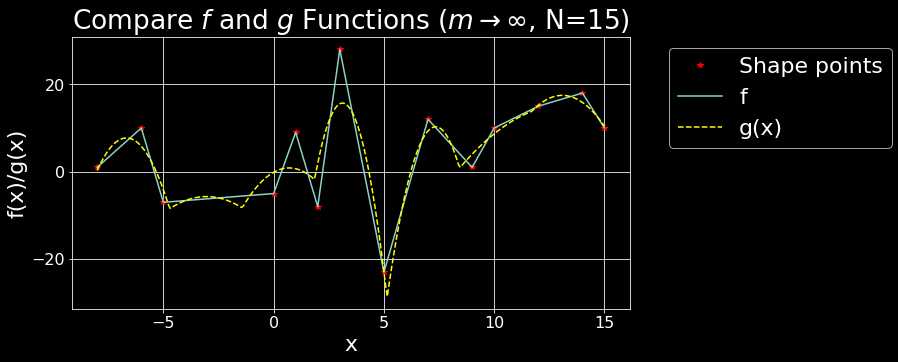

In [7]:
'''Plot comparison of f and g_best_vec with constrained end points'''
'''Pedagogical Gram matrix'''
def get_gram_matrix_cons(basis_func_list, domain_partition, inner_product):
    N = len(basis_func_list)
    patches = domain_partition[0]
    a_mtrx = np.zeros((N, N), dtype=np.float64)
    for i,phi_i in enumerate(basis_func_list):
        for j,phi_j in enumerate(basis_func_list):
            a_mtrx[i,j] = inner_product(phi_i, phi_j, patches)+phi_i(x_min)*phi_j(x_min)+phi_i(x_max)*phi_j(x_max)     
    return a_mtrx

'''Compute the Gram matrix'''
gram_mtrx_2 = get_gram_matrix_cons(phi_list, domain_partition, inner_product)

'''Build load vector'''
b_vec_2 = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]
for i, phi_i in enumerate(phi_list):
    b_vec_2[i] = inner_product(f, phi_i, patches)+phi_i(x_min)*f(x_min)+phi_i(x_max)*f(x_max)
    
'''Compute optimal coefficient vector'''
c_star_vec_const = np.linalg.solve(gram_mtrx_2, b_vec_2)

'''Plot comparison of f and g_best_vec'''
g_const=g(x_pts,c_star_vec_const)

plt.plot(Shape[:,0], Shape[:,1], '*', color='red',label='Shape points')
plt.plot(Shape[:,0], new_f,label='f')
plt.grid()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(x_pts,g_const,'--',label='g(x)', color='yellow')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('x');plt.ylabel("f(x)/g(x)")
plt.title(r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, N='+str(len(phi_list))+')')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show() 

In [8]:
'''L2 norm error'''
def f_integrand(x):
    return f(x)**2
f_integral = quad(f_integrand, x_min, x_max, limit=10000)
f_l2=np.sqrt(f_integral)

print(color+'||f||_L2 =%10.6f'%f_l2[0])
print(color+'quadrature error =%10.6e'%f_l2[1])

def g2_integrand(x):
    g_vec = g(np.array([x]),c_star_vec_const)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=10000)
print(color+'||g||_L2 =', math.sqrt(g2_integral))
print(color+'quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(np.array([x]))
    g_vec = g(np.array([x]),c_star_vec_const)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=10000)
print(color+'||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
print(color+'quadrature error =', error)
r_err=(math.sqrt(f_minus_g_2_integral)/np.sqrt(f_integral)*100)
print('')
print(color+'Relative error = %10.6f'%r_err[0],'%')

||f||_L2 = 49.507575
quadrature error =5.392697e-03

||g||_L2 = 47.537624390470896
quadrature error = 3.6006781556352507e-06

||f-g||_L2 = 13.542055294182653
quadrature error = 8.757600085118611e-07

Relative error =  27.353502 %


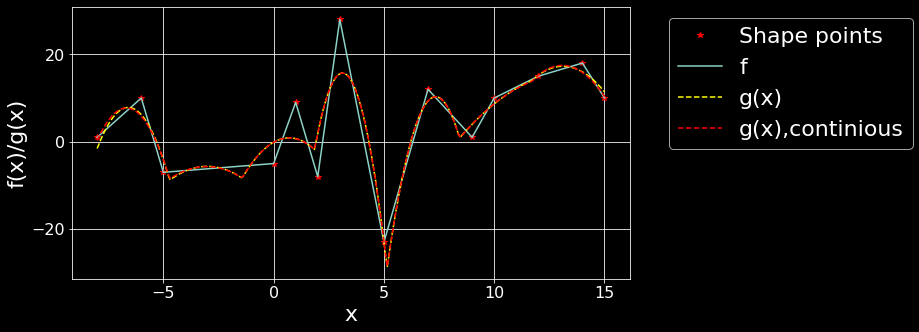

In [9]:
'''Code for comparison of constrained and unconstrainted methods'''
plt.plot(Shape[:,0], Shape[:,1], '*', color='red',label='Shape points')
plt.plot(Shape[:,0], Shape[:,1],label='f')
plt.grid()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(x_pts,g_best,'--',label='g(x)', color='yellow')
plt.plot(x_pts,g_const,'--',label='g(x),continious', color='red')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('x');plt.ylabel("f(x)/g(x)")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

<span style="color:blue">**Explanation:**</span>

As we constrain the endpoints the error become higher. So end point constrain is not a good option here.

## <span style="color:blue">[Assignment 2 (40 pts)](#toa)</span><a id="a2"></a>

### [Boundary-Value Problem Statement](#toa)<a id="poisson"></a>

Solve the heat conduction problem (nuclear fuel pin). Find $u:[a,b]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
 -\bigl(-k(x)\, u'\bigr)'(x) + S(x)\,u(x) + f(x) &= 0 \quad\quad \forall \quad\quad x\in [a,b], \\
 u(a) &= u_a, \\
 u(b) &= u_b.
\end{align*}
   
Given data: thermal conductivity coefficient, $k(x)$, source, $S(x)$ slope, source bias, $f(x)$.

### <span style="color:blue">[2.1)](#toa)(30 pts) Solve the above problem using the Rayleigh-Ritz method with Lagrange finite element basis functions. Use the least amount of basis functions in order to show a relative error in total energy conservation of less than 1%. Provide similar plots as below, and create a table of results as shown. Explain the method of solution and show the actual relative error in total energy conservation.
</span><a id="a21"></a>

## [Data](#toa)<a id="data"></a>

Solve problem with parameter values:

> + a = 1 cm
> + b = 4 cm
> + k = see plot below W/m/K
> + S = 0
> + f = see plot below W/m^3

Boundary conditions:

> + u_a = 450 C
> + u_b = 450 C

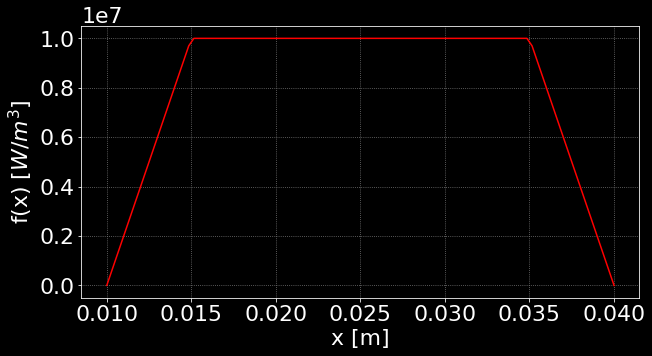

In [10]:
'''Source bias'''
x_a = 1*10**(-2) #m
x_b = 4*10**(-2) #m
'''Parameters and data'''
x_pts=np.linspace(x_a,x_b,100)

source_bias_shape_point=[(0.010,0),(0.015,1*10**7),(0.035,1*10**7),(0.040,0)]
source=np.array(source_bias_shape_point)
f_sb = interp1d(source[:,0],source[:,1])

plt.figure()
plt.plot(x_pts,f_sb(x_pts),color='red')
plt.grid(color='gray',linestyle=':',animated=True)
plt.xlabel('x [m]')
plt.ylabel(r'f(x) $[W/ m^3]$')
plt.show()

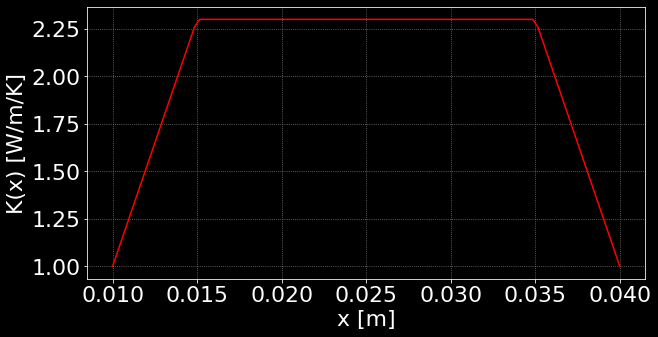

In [11]:
'''Thermal conductivity'''
Cond_shape_pts = [(0.01,1),(0.015,2.3),(0.035,2.3),(0.040,1)]
Cond=np.array(Cond_shape_pts)
plt.figure()
f_cond=interp1d(Cond[:,0],Cond[:,1])
plt.plot(x_pts,f_cond(x_pts),color='red')
plt.grid(color='gray',linestyle=':',animated=True)
plt.xlabel('x [m]')
plt.ylabel('K(x) [W/m/K]')
plt.show()

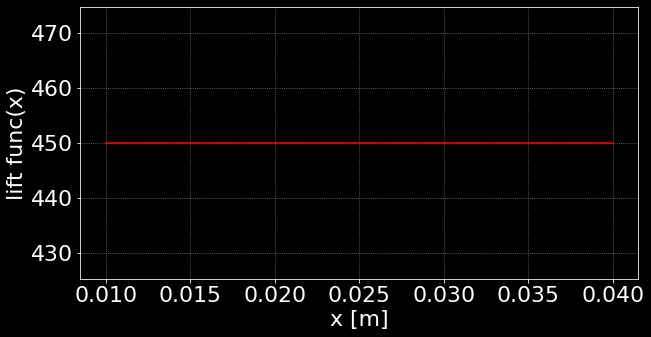

In [12]:
lift_sp=[(0.010,450),(0.040,450)]
lift=np.array(lift_sp)
w_x = interp1d(lift[:,0],lift[:,1])
plt.figure()
plt.plot(x_pts,w_x(x_pts),color='red')
plt.grid(color='gray')
plt.grid(color='gray',linestyle=':',animated=True)
plt.xlabel('x [m]')
plt.ylabel('lift func(x)')
plt.show()

In [13]:
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min=x_a
x_max=x_b

degree=2
n_elem=30

domain_partition = get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='essential', bc_x_max='essential')
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()


phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]



'''Pedagogical inner product'''


#Building of the dead matrix

A_mtrx = np.zeros((len(phi_list), len(phi_list)), dtype=np.float64)
patches = domain_partition[0]
for i in range(len(phi_list)):
    for j in range(len(phi_list)):
        
        phi_i=phi_list[i]
        phi_j=phi_list[j]
        
        phi_prime_i=phi_prime_list[i]
        phi_prime_j=phi_prime_list[j]
        
        h_e=(x_max-x_min)/n_elem
        
        d_x_phi_prime_j = lambda x: f_cond(x) *(2/h_e)* phi_prime_j(x)
        prima = lambda x: phi_prime_i(x)*(2/h_e)

        A_mtrx[i,j] = inner_product(prima, d_x_phi_prime_j, patches)
        
def load_vec(f_sb):
    b_vec = np.zeros(len(phi_list), dtype=np.float64)
    patches = domain_partition[0]
    for i, phi_i in enumerate(phi_list):
        b_vec[i] = inner_product(f_sb, phi_i, patches)
    return b_vec
b_vec=load_vec(f_sb)
#print(b_vec)
'''Compute optimal coefficient vector'''
c_star_vec = np.linalg.solve(A_mtrx, b_vec)


def u_star(x):
    g_x=w_x(x)
    for (j,phi_i) in enumerate(phi_list):
        g_x=g_x+(c_star_vec[int(j)])*phi_i(x)
    return g_x


def u_star_prime(x):
    g_x=0
    for (j,phi_prime_i) in enumerate(phi_prime_list):
        g_x=g_x+(c_star_vec[int(j)])*(2/h_e)*phi_prime_i(x)
    return g_x



'''Flux at boundary'''
print(color+'q_na computed = ', -f_cond(x_min)*u_star_prime(x_min))
print(color+'q_nb computed = ', -f_cond(x_max)*u_star_prime(x_max))
#print('q_nb given    = ', q_nb)
#print('flux error [%]= ',(-f_cond(x_max)*g_prime(x_max) - q_nb)/q_nb*100)

q_na computed =  [-124023.28386387]
q_nb computed =  [124023.28386387]


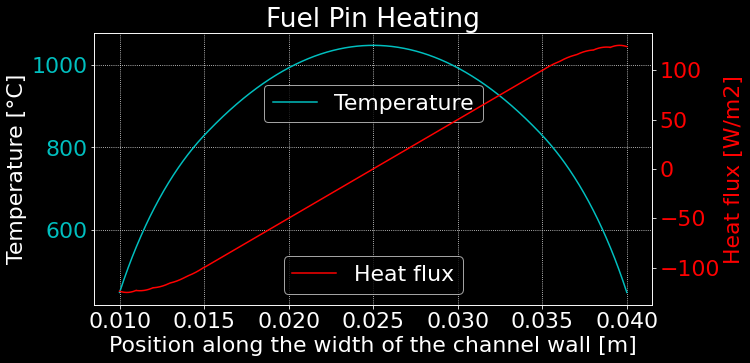

In [14]:
def plot_result(npts=200,item1='Both',title=''):
    if item1=='Both':
        fig, ax1 = plt.subplots()
        plt.grid(color='white',linestyle=':',animated=True)
        ax2 = ax1.twinx()
        ax1.plot(np.linspace(x_min,x_max,2000),u_star(np.linspace(x_min,x_max,2000)),label='Temperature',color='c')
        ax1.tick_params(axis='y', labelcolor='c')
        ax2.plot(np.linspace(x_min,x_max,2000),-f_cond(np.linspace(x_min,x_max,2000))*(1/1000)*u_star_prime((np.linspace(x_min,x_max,2000))),color='red',label='Heat flux')
        ax2.tick_params(axis='y', labelcolor='r')
        ax1.set_xlabel("Position along the width of the channel wall [m]")
        ax1.set_ylabel('Temperature [°C]')
        ax2.set_ylabel('Heat flux [W/m2]',color='red')
        #fig.set_size_inches(15,10)
        ax1.legend(loc='upper center',bbox_to_anchor=(0.5, 0.85))
        ax2.legend(loc='lower center')
        plt.title(title)
        plt.show()

plot_result(npts=200,item1='Both',title='Fuel Pin Heating')


In [15]:
'''Table of results'''
print(' ' ' ' ' ' ' x [cm]  '' T [°C]   q_x [kW/m^2]')
print(Fore.RED+'---------------------------------------')
for i, pat in enumerate(patches):
    print(color+'%2i) %4.2f     %5.2f    %5.2f'% (i+1, pat[0]*100,u_star(pat[0]),-f_cond(pat[0])*(1/1000)*u_star_prime(pat[0])))
print(color+'40) %4.2f     %5.2f    %5.2f'% (x_max*100,u_star(x_max),-f_cond(x_max)*(1/1000)*u_star_prime(x_max)))
#print( x_pts,-f_cond(x_pts)*(1/1000)*u_star_prime(x_pts))

    x [cm]   T [°C]   q_x [kW/m^2]
---------------------------------------
 1) 1.00     450.00    -124.02
 2) 1.10     560.83    -123.02
 3) 1.20     649.37    -120.36
 4) 1.30     721.48    -115.54
 5) 1.40     780.60    -108.66
 6) 1.50     828.93    -99.74
 7) 1.60     870.24    -90.00
 8) 1.70     907.19    -80.00
 9) 1.80     939.80    -70.00
10) 1.90     968.06    -60.00
11) 2.00     991.98    -50.00
12) 2.10     1011.54    -40.00
13) 2.20     1026.76    -30.00
14) 2.30     1037.63    -20.00
15) 2.40     1044.15    -10.00
16) 2.50     1046.32     0.00
17) 2.60     1044.15    10.00
18) 2.70     1037.63    20.00
19) 2.80     1026.76    30.00
20) 2.90     1011.54    40.00
21) 3.00     991.98    50.00
22) 3.10     968.06    60.00
23) 3.20     939.80    70.00
24) 3.30     907.19    80.00
25) 3.40     870.24    90.00
26) 3.50     828.93    100.00
27) 3.60     780.60    108.74
28) 3.70     721.48    115.66
29) 3.80     649.37    120.54
30) 3.90     560.83    123.36
40) 4.00     450.00  

In [16]:
'''Total energy balance'''
(Total_power, _)= quad(f_sb, x_min, x_max)

flux_left=-f_cond(x_min)*u_star_prime(x_min)
flux_right=-f_cond(x_max)*u_star_prime(x_max)

print('Total energy balance relative error [%%] = %2.2f '%(100*(abs(flux_left) + abs(flux_right)- Total_power)/Total_power))

Total energy balance relative error [%] = -0.78 


The Rayleigh-Ritz method for computing an approximate solution to the above mentioned Poisson problem is: find $u^*_N \in V_N(a,b)\subset V(a,b) = \bigl\{ u:[a,b]\subset\Reals\rightarrow\Reals \bigr\}$ such that it minimizes the Poisson energy norm:

\begin{equation*}
  \norm{u-u^*_N}^2_{\epsilon} = \min\limits_{u_N\, \in\, V_N} \norm{u-u_N}^2_{\epsilon},
\end{equation*}

where 
$V_N(a,b) := \bigl\{ u_N = \sum\limits_{i=1}^N\,c_i\,\phi_i \mid u_N(a) = u_N(b) = 0, (u'_N,u'_N) < \infty \bigr\}$
and $\{\phi_i\mid i=1\ldots,N\}$ is a basis of $V_N(a,b)$.

The optimum coefficients $\cvec^* := \{c_i\mid i=1,\ldots,N\}$ solve

\begin{equation*}
 \overset{(N\times N)}{\Amtrx}\,\overset{(N\times 1)}{\cvec^*} = \overset{(N\times 1)}\bvec ,
\end{equation*}

where:
  + $A_{i,j} = (D\,\phi'_i,\phi'_j) - (S\,\phi_i,\phi_j)$
  + $b_i = (f,\phi_i)$
  
This formulation only accommodates basis functions that satisfy the homogeneous boundary conditions.

### <span style="color:blue">[2.2)](#toa)(35 pts) Solve the same problem in 2.1) using the data modified source below. Use the least amount of basis functions in order to show a relative error in total energy conservation of less than 1%. Show the actual relative error in total energy conservation. Create a table of results as shown below, and compute the loss in nuclear heating power.
</span><a id="a22"></a>

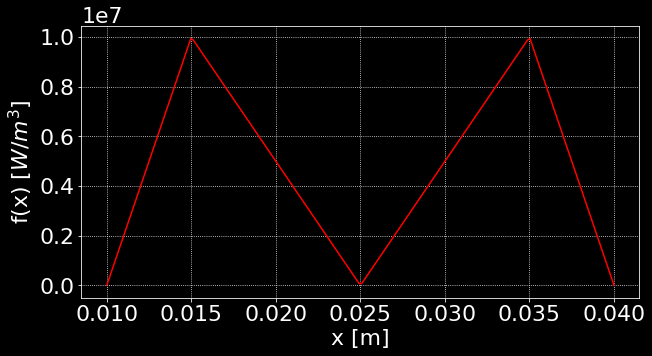

In [17]:
'''Source bias'''
Source_shape_pts = [(0.01,0),(0.015,1E7),(0.025,0),(0.035,1E7),(0.04,0)]
source=np.array(Source_shape_pts)
f_sb=interp1d(source[:,0],source[:,1])


plt.figure()
plt.plot(np.linspace(0.01,0.04,200),f_sb(np.linspace(0.01,0.04,200)),color='red')
plt.grid(color='white',linestyle=':',animated=True)
plt.xlabel('x [m]')
plt.ylabel(r'f(x) $[W/ m^3]$')
plt.show()

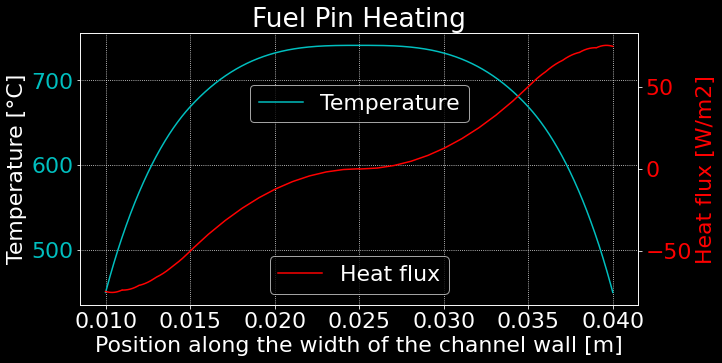

In [18]:
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
b_vec=load_vec(f_sb)

c_star_vec = np.linalg.solve(A_mtrx, b_vec)

plot_result(npts=200,item1='Both',title='Fuel Pin Heating')

In [19]:
'''Table of results'''
print(' ' ' ' ' ' ' x [cm]  '' T [°C]   q_x [kW/m^2]')
print(Fore.RED+'---------------------------------------')

for i, pat in enumerate(patches):
    print(color+'%2i) %4.2f     %5.2f    %5.2f'% (i+1, pat[0]*100,u_star(pat[0]),-f_cond(pat[0])*(1/1000)*u_star_prime(pat[0])))
print(color+'40) %4.2f     %5.2f    %5.2f'% (x_max*100,u_star(x_max),-f_cond(x_max)*(1/1000)*u_star_prime(x_max)))

    x [cm]   T [°C]   q_x [kW/m^2]
---------------------------------------
 1) 1.00     450.00    -74.47
 2) 1.10     516.39    -73.47
 3) 1.20     568.85    -70.65
 4) 1.30     610.59    -65.75
 5) 1.40     643.50    -58.81
 6) 1.50     668.76    -49.86
 7) 1.60     688.40    -40.42
 8) 1.70     704.12    -31.92
 9) 1.80     716.37    -24.42
10) 1.90     725.57    -17.92
11) 2.00     732.17    -12.42
12) 2.10     736.59    -7.92
13) 2.20     739.27    -4.42
14) 2.30     740.64    -1.92
15) 2.40     741.15    -0.42
16) 2.50     741.22     0.08
17) 2.60     741.15     0.42
18) 2.70     740.64     1.92
19) 2.80     739.27     4.42
20) 2.90     736.59     7.92
21) 3.00     732.17    12.42
22) 3.10     725.57    17.92
23) 3.20     716.37    24.42
24) 3.30     704.12    31.92
25) 3.40     688.40    40.42
26) 3.50     668.76    49.92
27) 3.60     643.50    58.86
28) 3.70     610.59    65.81
29) 3.80     568.85    70.75
30) 3.90     516.39    73.65
40) 4.00     450.00    74.47


In [20]:
'''Total energy balance'''
(Total_power_prim, _)= quad(f_sb, x_min, x_max)

flux_left=-f_cond(x_min)*u_star_prime(x_min)
flux_right=-f_cond(x_max)*u_star_prime(x_max)

print(color+'Total energy balance relative error [%%] = %2.2f '%(100*(abs(flux_left) + abs(flux_right)- Total_power_prim)/Total_power_prim))

Total energy balance relative error [%] = -0.71 


In [21]:
'''Power loss'''
print(color+'Power loss = %2.2f [%%]'%((Total_power_prim-Total_power)/Total_power*100))

Power loss = -40.00 [%]


## <span style="color:blue">[Assignment 3 (5 pts)](#toa)</span><a id="a3"></a>

### <span style="color:blue">Describe the most unclear point in the content presented so far. Then, make an effort to clarify the point on your own.</span>

<span style="color:blue">**Answer:**</span>

In [ ]:
How one should discide the lift func.
    